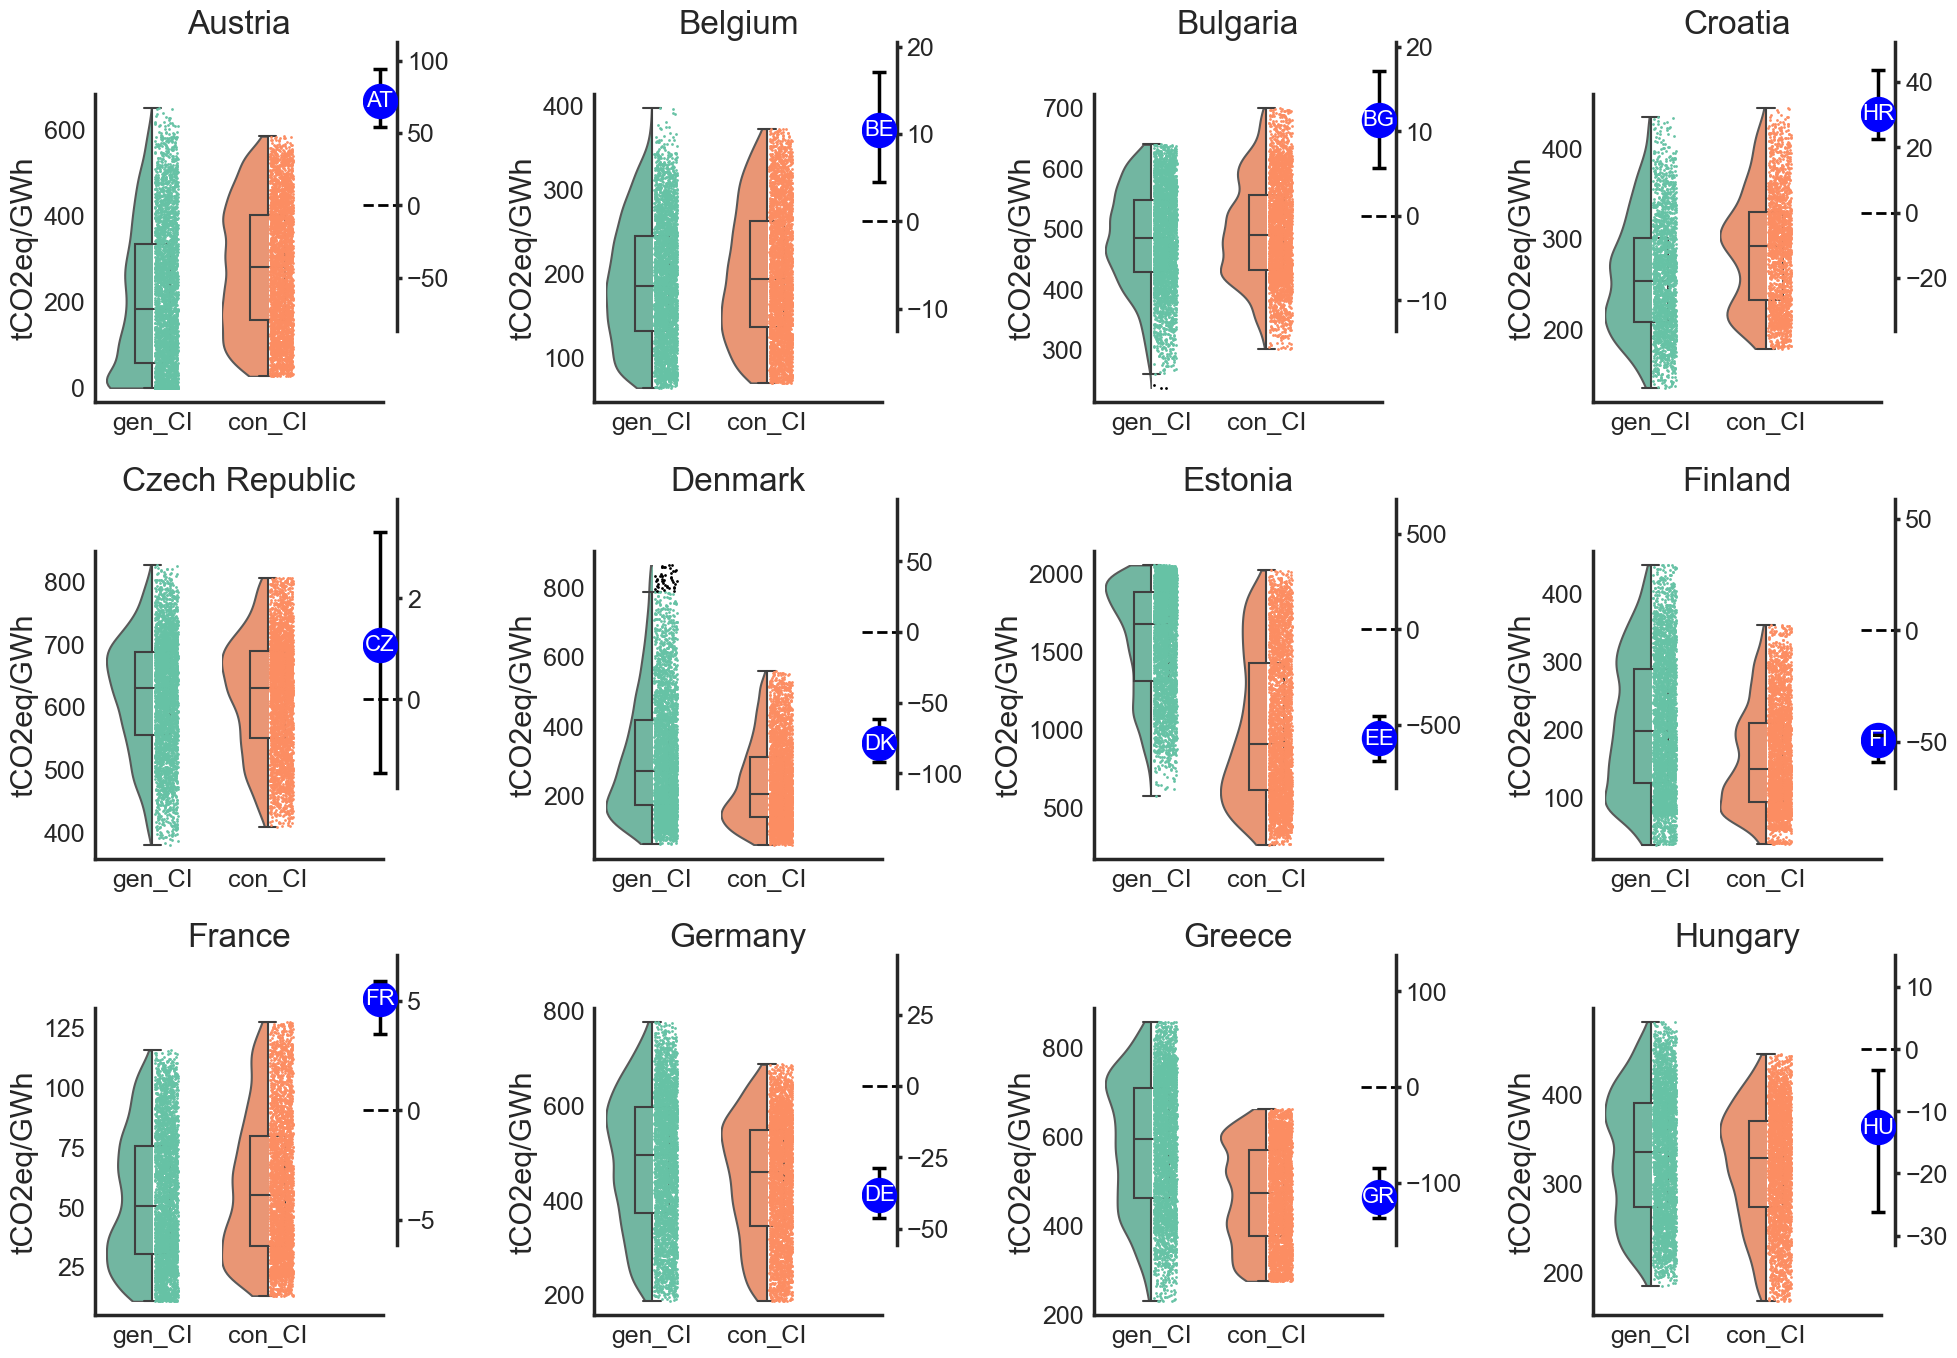

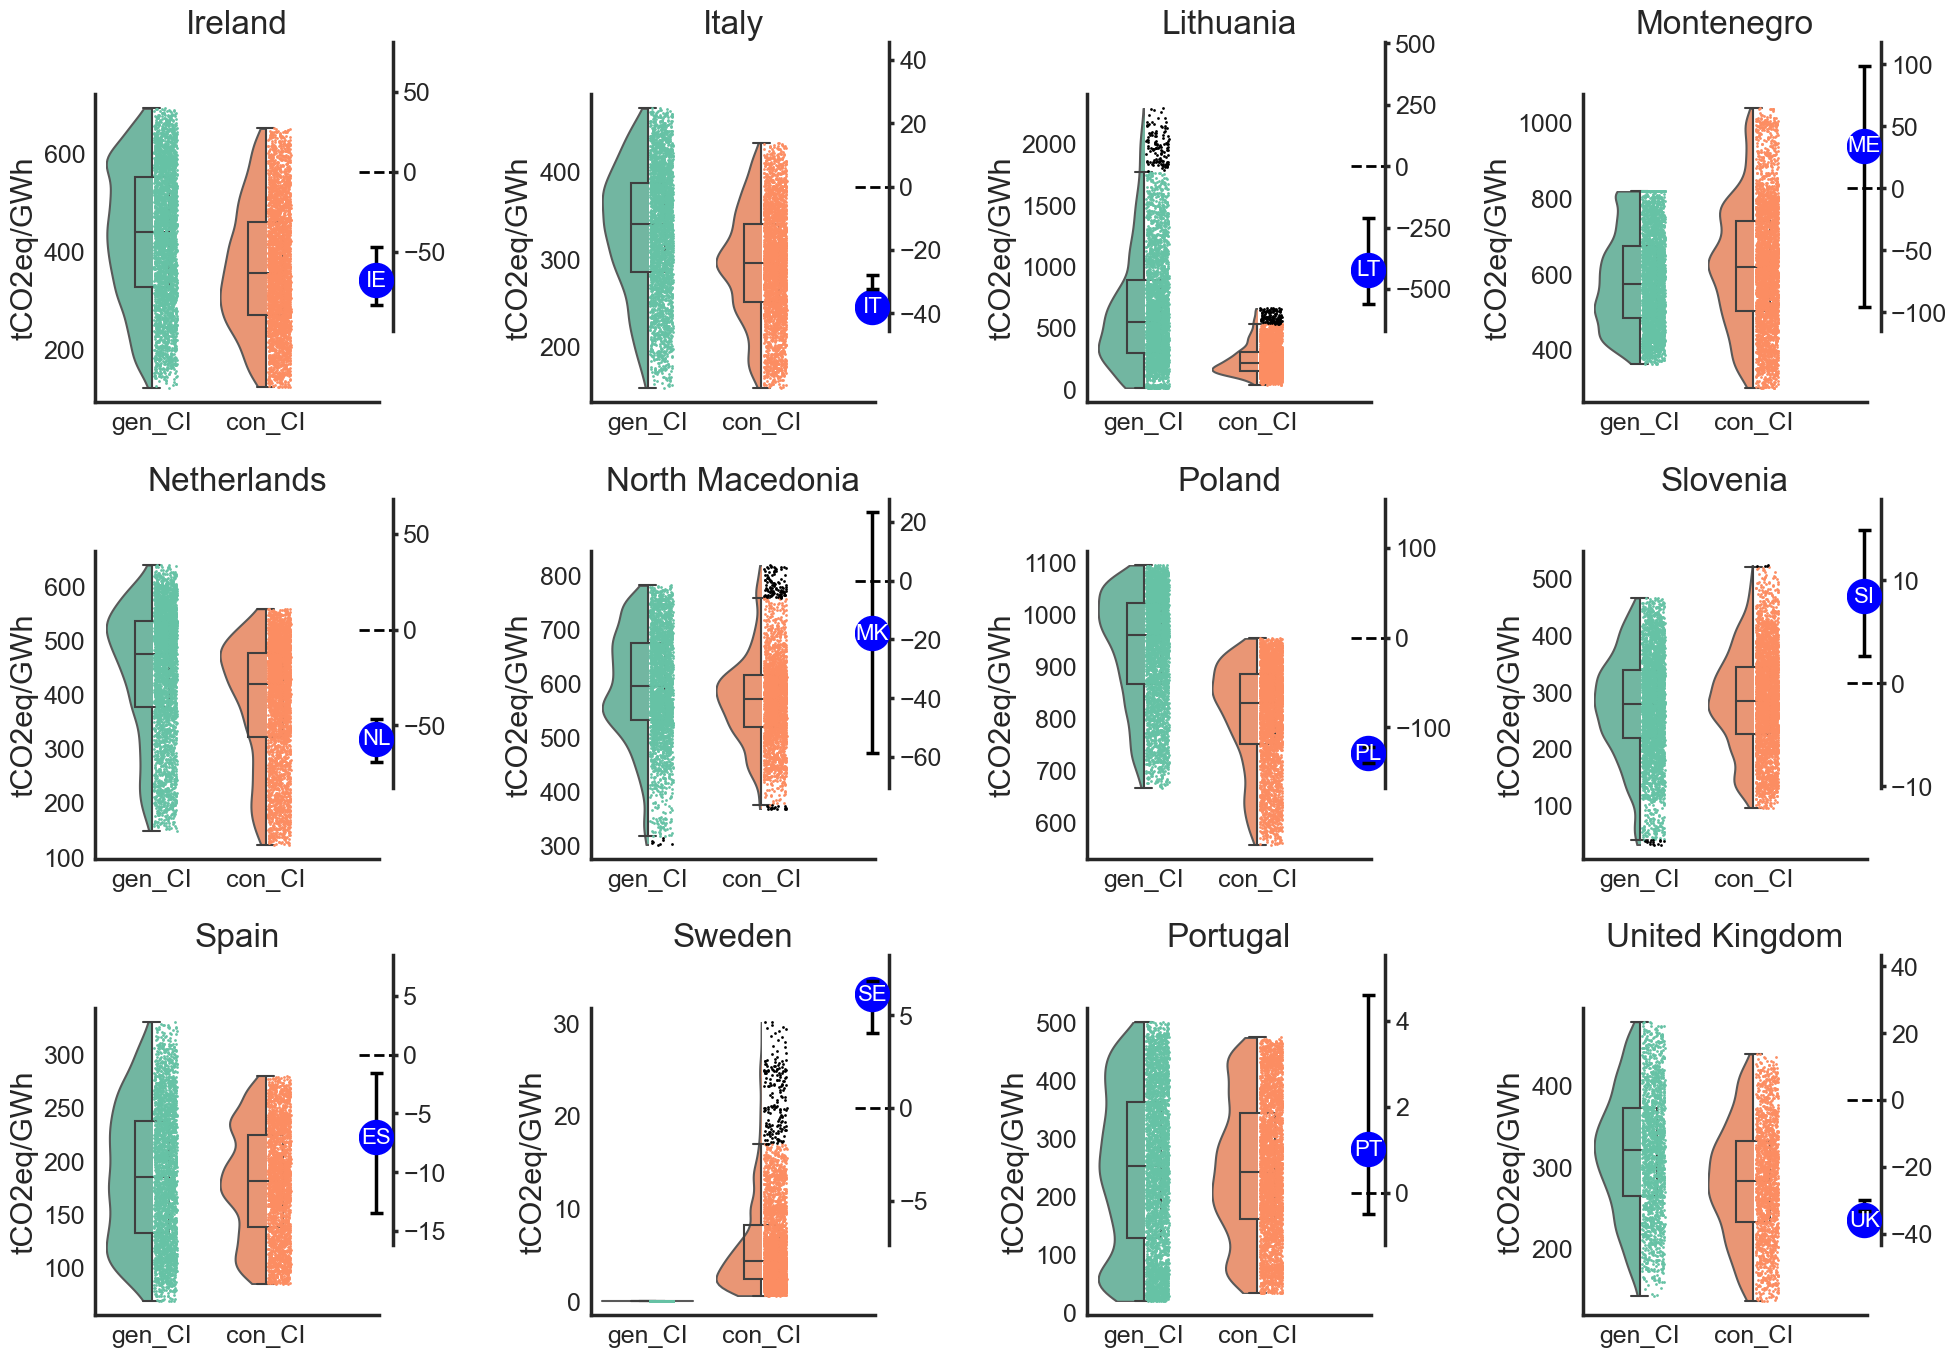

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a function to filter data within the 1-99 percentiles
def filter_percentile(df, column, lower=0.01, upper=0.99):
    lower_bound = df[column].quantile(lower)
    upper_bound = df[column].quantile(upper)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


# Load the data
data = pd.read_csv('./Main_data_2015_2024_real0.csv')

# Country abbreviations for two-letter codes
country_abbrev = {
    'Austria': 'AT',
    'Belgium': 'BE',
    'Bulgaria': 'BG',
    'Croatia': 'HR',
    'Czech Republic': 'CZ',
    'Denmark': 'DK',
    'Estonia': 'EE',
    'Finland': 'FI',
    'France': 'FR',
    'Germany': 'DE',
    'Greece': 'GR',
    'Hungary': 'HU',
    'Ireland': 'IE',
    'Italy': 'IT',
    'Lithuania': 'LT',
    'Montenegro': 'ME',
    'Netherlands': 'NL',
    'North Macedonia': 'MK',
    'Poland': 'PL',
    'Slovenia': 'SI',
    'Spain': 'ES',
    'Sweden': 'SE',
    'Portugal': 'PT',
    'United Kingdom': 'UK'
}

# Filter data for selected countries, including only the countries specified in country_sel
country_sel = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Lithuania', 'Montenegro', 'Netherlands', 'North Macedonia', 'Poland', 'Slovenia', 'Spain', 'Sweden', 'Portugal', 'United Kingdom']

data = data[data['country'].isin(country_sel)]

# Country-specific filtering
constraints = {
    'Croatia': ('2019-01', None),
    'Georgia': ('2022-01', None),
    'Italy': ('2016-01', None),
    'Kosovo': ('2022-01', None),
    'Luxembourg': ('2022-01', None),
    'Moldova': ('2022-01', None),
    'Norway': ('2017-01', None),
    'Serbia': ('2017-01', None),
    'Spain': ('2017-01', None),
    'United Kingdom': ('2016-01', '2021-01')
}

# List of countries to delete
countries_to_delete = ['Bosnia and Herz', 'Cyprus', 'Ukraine']

# Filter out unwanted countries
data = data[~data['country'].isin(countries_to_delete)]

# Apply country-specific date constraints
for country, (start_date, end_date) in constraints.items():
    if start_date and end_date:
        data = data[(data['country'] != country) | ((data['date'] >= start_date) & (data['date'] <= end_date))]
    elif start_date:
        data = data[(data['country'] != country) | (data['date'] >= start_date)]

# Dictionary to store the yearly differences for each country
yearly_diff_dict = {}

filtered_data = pd.DataFrame()
outlier_data = pd.DataFrame()  # 新增：存储所有国家的 outliers

for country in data['country'].unique():
    country_data = data[data['country'] == country]

    # 提取 generation_CI 异常值
    gen_q1 = country_data['generation_CI'].quantile(0.01)
    gen_q99 = country_data['generation_CI'].quantile(0.99)
    gen_outliers = country_data[(country_data['generation_CI'] < gen_q1) | (country_data['generation_CI'] > gen_q99)]
    gen_outliers = gen_outliers[['date', 'generation_CI']].copy()
    gen_outliers['type'] = 'generation_CI'
    gen_outliers = gen_outliers.rename(columns={'generation_CI': 'value'})
    gen_outliers['country'] = country

    # 提取 consumption_CI 异常值
    con_q1 = country_data['consumption_CI'].quantile(0.01)
    con_q99 = country_data['consumption_CI'].quantile(0.99)
    con_outliers = country_data[(country_data['consumption_CI'] < con_q1) | (country_data['consumption_CI'] > con_q99)]
    con_outliers = con_outliers[['date', 'consumption_CI']].copy()
    con_outliers['type'] = 'consumption_CI'
    con_outliers = con_outliers.rename(columns={'consumption_CI': 'value'})
    con_outliers['country'] = country

    # 合并两类 outliers，添加到总 outlier_data 中
    outlier_data = pd.concat([outlier_data, gen_outliers, con_outliers], ignore_index=True)

    # Filter percentiles and build filtered_data as原本逻辑
    filtered_country_data = filter_percentile(country_data, 'generation_CI')
    filtered_country_data = filter_percentile(filtered_country_data, 'consumption_CI')

    filtered_data = pd.concat([filtered_data, filtered_country_data])

    # Yearly stats（略）
    filtered_country_data['date'] = pd.to_datetime(filtered_country_data['date'])
    yearly_means = filtered_country_data.groupby(filtered_country_data['date'].dt.year)[['consumption_CI', 'generation_CI']].mean()
    yearly_diff = yearly_means['consumption_CI'] - yearly_means['generation_CI']
    yearly_diff_dict[country] = yearly_diff


# Now use `filtered_data` for plotting instead of `data`
data = filtered_data

# Set up for plotting all countries in one figure with 4x3 grid
sns.set_style('white')
palette = 'Set2'

# Set global font size and remove right/top spines
plt.rcParams.update({
    'font.size': 20,         # Global font size
    'axes.titlesize': 24,    # Title font size
    'axes.labelsize': 22,    # Axis labels font size
    'xtick.labelsize': 18,   # X-axis tick labels font size
    'ytick.labelsize': 18,   # Y-axis tick labels font size
    'legend.fontsize': 20,   # Legend font size
    'figure.titlesize': 26   # Figure title font size
})

# Create plots for every 12 countries in separate figures
for batch_start in range(0, len(country_sel), 12):
    countries_batch = country_sel[batch_start:batch_start + 12]
    
    # Create the figure and axes for subplots
    n_countries = len(countries_batch)
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 14))
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    # Loop through each country in the batch and assign its plot to the corresponding subplot
    for i, country in enumerate(countries_batch):
        country_data = data[data['country'] == country]

        # Convert the 'date' column to a datetime object for grouping by year
        country_data['date'] = pd.to_datetime(country_data['date'])
        
        # Calculate yearly means for consumption_CI and generation_CI
        yearly_means = country_data.groupby(country_data['date'].dt.year)[['consumption_CI', 'generation_CI']].mean()
        
        # Calculate the yearly differences (average consumption_CI - average generation_CI)
        yearly_diff = yearly_means['consumption_CI'] - yearly_means['generation_CI']
        
        # Calculate the mean, 25th, and 75th percentiles of the yearly differences
        mean_diff = yearly_diff.mean()
        q25_diff = yearly_diff.quantile(0.25)
        q75_diff = yearly_diff.quantile(0.75)

        # Melt the data for easier plotting (converting generation_CI and consumption_CI into a long format)
        melted_data = pd.melt(country_data, id_vars=["date"], value_vars=["generation_CI", "consumption_CI"],
                            var_name="type", value_name="value")
        
        ax = axes[i]  # Select the appropriate subplot

        # Plot violin plot with cut=0 to restrict the violin plot to the data range
        sns.violinplot(x="type", y="value", data=melted_data, palette=palette, scale="width", inner=None, ax=ax, cut=0)
        
        # Get limits before clipping the violin
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        # Clip each violin to only show half
        for violin in ax.collections:
            bbox = violin.get_paths()[0].get_extents()
            x0, y0, width, height = bbox.bounds
            violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax.transData))
        
        # Add boxplot
        sns.boxplot(x="type", y="value", data=melted_data, saturation=1, showfliers=False,
                    width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=ax)
        
        # Add scatter points (stripplot) with smaller point size
        old_len_collections = len(ax.collections)
        # sns.stripplot(x="type", y="value", data=melted_data, palette=palette, dodge=False, ax=ax, size=2)  # Reduced point size
        # 分别绘制非异常值（彩色）和异常值（黑色）
        
        custom_palette = {
            'generation_CI': '#66c2a5',  # 对应 Set2 的第一个颜色
            'consumption_CI': '#fc8d62'  # 对应 Set2 的第二个颜色
        }
        
        # 先绘制非离群点（用调色板颜色）
        for var in ['generation_CI', 'consumption_CI']:
            subset = melted_data[melted_data['type'] == var]
            q1 = subset['value'].quantile(0.25)
            q3 = subset['value'].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            non_outliers = subset[(subset['value'] >= lower_bound) & (subset['value'] <= upper_bound)]
            sns.stripplot(
                x='type', y='value', data=non_outliers,
                color=custom_palette[var], dodge=False, ax=ax, size=2, jitter=True, zorder=4
            )

        # 再绘制离群点（用黑色，保持 stripplot 的 jitter 和样式）
        for var in ['generation_CI', 'consumption_CI']:
            subset = melted_data[melted_data['type'] == var]
            q1 = subset['value'].quantile(0.25)
            q3 = subset['value'].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            outliers = subset[(subset['value'] < lower_bound) | (subset['value'] > upper_bound)]
            sns.stripplot(
                x='type', y='value', data=outliers,
                color='black', dodge=False, ax=ax, size=2, jitter=True, zorder=5
            )

        # Adjust scatter points to avoid overlap
        for dots in ax.collections[old_len_collections:]:
            dots.set_offsets(dots.get_offsets() + np.array([0.12, 0]))
        
        # Set title and remove legend
        ax.set_title(f'{country}')
        if ax.legend_:
            ax.legend_.remove()
        
        # Thicken left and bottom spines (for main plot), and remove right and top
        ax.spines['left'].set_linewidth(2.5)
        ax.spines['bottom'].set_linewidth(2.5)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Adjust the ticks (make y-ticks thicker and point outward)
        ax.tick_params(axis='y', direction='out', width=4)
        ax.tick_params(axis='x', width=2.5)

        # Extend x-axis a bit to the right to make room for the inset
        xlim = ax.get_xlim()
        ax.set_xlim(xlim[0], xlim[1] + 0.5)

        # Remove x-axis label (type label)
        ax.set_xlabel('')

        # Change x-axis labels to 'gen_CI' and 'con_CI'
        ax.set_xticklabels(['gen_CI', 'con_CI'])

        # Set y-axis label to "tCO2eq/GWh" for the main plot
        ax.set_ylabel('tCO2eq/GWh')

        # Add inset axes for generation_CI - consumption_CI boxplot
        # inset_ax = ax.inset_axes([0.93, 0.53, 0.12, 0.54], facecolor='none')  # Adjust the position to top-right corner
        inset_ax = ax.inset_axes([0.93, 0.23, 0.12, 0.94], facecolor='none')  # Adjust the position to top-right corner

        # Add a blue scatter point for the mean difference
        inset_ax.scatter([0], [mean_diff], color='blue', s=600, zorder=5)  # Larger blue point

        # Add whiskers for the 25th and 75th percentiles
        inset_ax.vlines(0, q25_diff, q75_diff, color='black', linestyle='-', linewidth=2.5, zorder=4)  # IQR whiskers

        # Add country abbreviation in white on top of the blue marker
        inset_ax.text(0, mean_diff, country_abbrev[country], color='white', fontsize=16, ha='center', va='center', zorder=6)

        # Add horizontal lines at the 25th and 75th percentiles (whisker tops)
        inset_ax.hlines(q25_diff, -0.1, 0.1, color='black', linewidth=2.5, zorder=5)  # 25th percentile line
        inset_ax.hlines(q75_diff, -0.1, 0.1, color='black', linewidth=2.5, zorder=5)  # 75th percentile line
        
        # # Add blue borders (spines) around the inset axes
        # for spine in inset_ax.spines.values():
        #     spine.set_edgecolor('blue')  # Set the edge color to blue
        #     spine.set_linewidth(2.5)     # Set the border width to 2.5


        # Only keep the right and top spines for the inset
        inset_ax.spines['left'].set_visible(False)
        inset_ax.spines['bottom'].set_visible(False)
        inset_ax.spines['top'].set_visible(False)
        inset_ax.spines['right'].set_linewidth(2.5)

        # Add a dashed horizontal line at y=0 in the inset
        inset_ax.axhline(y=0, color='black', linestyle='--', linewidth=2)

        # Adjust y-limits to accommodate whiskers (IQR range)
        lower_limit = min(q25_diff * 1.2, -abs(mean_diff) * 1.2)
        upper_limit = max(q75_diff * 1.2, abs(mean_diff) * 1.2)
        inset_ax.set_xlim(-0.25, 0.25)
        inset_ax.set_ylim(lower_limit, upper_limit)  # Symmetric limits around 0

        # Display y-axis ticks on the right in the inset, remove left ticks, increase font size and thickness
        inset_ax.tick_params(axis='y', labelsize=18, width=2.5, right=True, labelright=True, left=False, labelleft=False)
        inset_ax.set_xticks([])  # Remove x-axis ticks
        inset_ax.set_xlabel('')

        # Set y-axis label for the inset to "tCO2eq/GWh" and move it outside the right edge
        # inset_ax.set_ylabel('tCO2eq/GWh', fontsize=12, labelpad=20)
        inset_ax.yaxis.set_label_position('right')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

    # Close the figure to free up memory
    plt.close(fig)

# The dictionary `yearly_diff_dict` now stores the yearly differences for each country.